In [21]:
import os, glob, numpy as np, pandas as pd
import librosa, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
print("TensorFlow:", tf.__version__)
print("Librosa:", librosa.__version__)

TensorFlow: 2.20.0
Librosa: 0.11.0


In [46]:
print("Searching for .wav files...")
wav_files = []
for root, dirs, files in os.walk('/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess'):
    wav_count = sum(1 for f in files if f.endswith('.wav'))
    if wav_count > 0:
        print(f"{root}: {wav_count} .wav files")
        wav_files.extend([os.path.join(root, f) for f in files if f.endswith('.wav')])

print(f"\nFound {len(wav_files)} total .wav files")

EMOTION_MAP = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

def parse_ravdess_filename(path):
    filename = os.path.basename(path).replace(".wav", "")
    parts = filename.split("-")
    if len(parts) >= 7:
        emotion_code = parts[2]
        actor_id = int(parts[6])
        emotion = EMOTION_MAP.get(emotion_code, "unknown")
        gender = "male" if actor_id % 2 == 1 else "female"
        return emotion, gender
    return "unknown", "unknown"

data = []
for path in wav_files:
    emotion, gender = parse_ravdess_filename(path)
    if emotion != "unknown":
        data.append({"path": path, "emotion": emotion, "gender": gender})

df = pd.DataFrame(data)
print(f"\nDataset: {len(df)} valid files")
print("\nEmotion distribution:")
print(df['emotion'].value_counts().sort_index())
print("\nSample files:")
print(df.head())


Searching for .wav files...
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song_Actors_01-24/Actor_16: 44 .wav files
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song_Actors_01-24/Actor_11: 44 .wav files
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song_Actors_01-24/Actor_20: 44 .wav files
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song_Actors_01-24/Actor_21: 44 .wav files
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song_Actors_01-24/Actor_19: 44 .wav files
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song_Actors_01-24/Actor_10: 44 .wav files
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song_Actors_01-24/Actor_17: 44 .wav files
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song_Actors_01-24/Actor_04: 44 .wav files
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song_Actors_01-24/Actor_03: 44 .wav files
/Users/pranit/Documents/Code/Wardrobe App/AI/ravdess/Audio_Song

In [23]:
# Parameters
SR = 16000
DUR = 3.0
N_SAMPLES = int(SR * DUR)
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 256

def load_and_trim(path):
    y, _ = librosa.load(path, sr=SR, mono=True)
    y, _ = librosa.effects.trim(y, top_db=30)
    if len(y) < N_SAMPLES:
        y = np.pad(y, (0, N_SAMPLES - len(y)))
    else:
        y = y[:N_SAMPLES]
    return y

def logmel_spectrogram(y):
    """Convert to Log-Mel spectrogram"""
    S = librosa.feature.melspectrogram(
        y=y, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    S_db = (S_db - S_db.mean()) / (S_db.std() + 1e-6)
    return S_db.astype(np.float32)

def preprocess_to_image(path):
    """Full pipeline: audio → Log-Mel image"""
    y = load_and_trim(path)
    S = logmel_spectrogram(y)
    return S[..., np.newaxis]  # Shape: (64, time_steps, 1)

# Test preprocessing
sample_path = df.iloc[0]['path']
X_sample = preprocess_to_image(sample_path)
print(f"Input shape: {X_sample.shape}")
print(f"Time steps: {X_sample.shape[1]}")


Input shape: (64, 188, 1)
Time steps: 188


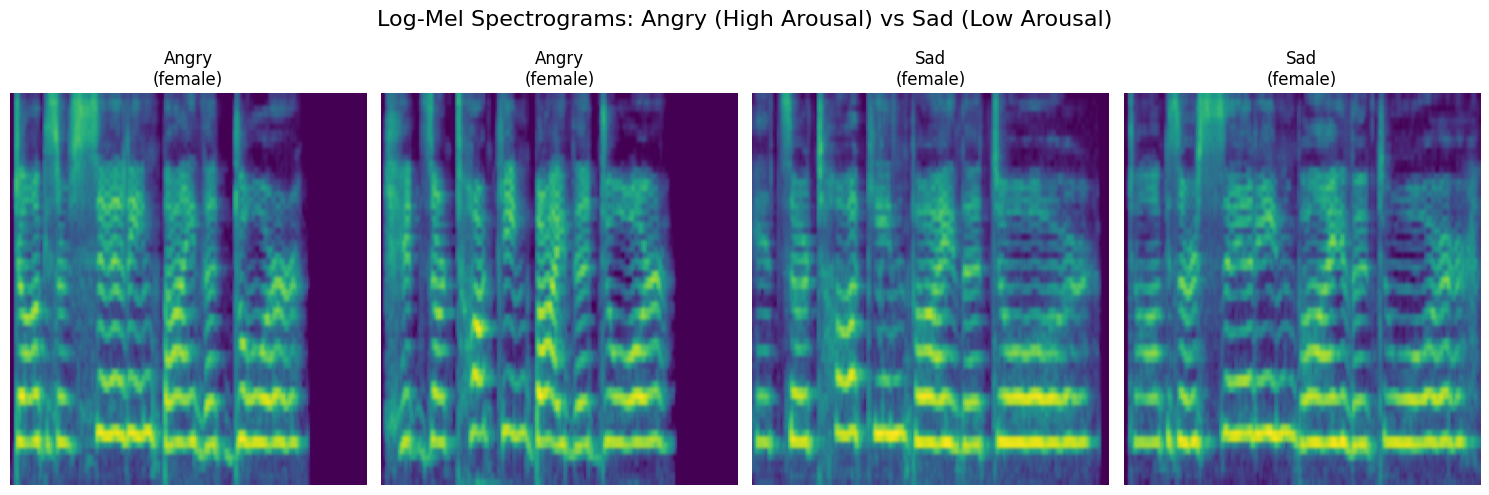

In [24]:
# Phase 1 requirement: Compare high vs low arousal emotions
plt.figure(figsize=(15, 5))

# Sample Angry and Sad
angry_files = df[df.emotion == 'angry'].head(2)
sad_files = df[df.emotion == 'sad'].head(2)

files_to_plot = []
for _, row in angry_files.iterrows():
    files_to_plot.append((row['path'], row['emotion'], row['gender']))
for _, row in sad_files.iterrows():
    files_to_plot.append((row['path'], row['emotion'], row['gender']))

for i, (path, emotion, gender) in enumerate(files_to_plot):
    plt.subplot(1, 4, i+1)
    S = preprocess_to_image(path)[:, :, 0]  # Remove channel for plotting
    plt.imshow(S, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{emotion.title()}\n({gender})")
    plt.axis('off')

plt.suptitle("Log-Mel Spectrograms: Angry (High Arousal) vs Sad (Low Arousal)", fontsize=16)
plt.tight_layout()
plt.show()


In [25]:
def augment_noise(y, snr_db=20):
    sig_power = np.mean(y**2) + 1e-9
    noise_power = sig_power / (10**(snr_db/10))
    noise = np.random.randn(len(y)) * np.sqrt(noise_power)
    return y + noise

def augment_pitch(y, steps=2):
    return librosa.effects.pitch_shift(y, sr=SR, n_steps=steps)

def augment_time_stretch(y, rate=1.1):
    y_stretch = librosa.effects.time_stretch(y, rate=rate)
    if len(y_stretch) < N_SAMPLES:
        y_stretch = np.pad(y_stretch, (0, N_SAMPLES - len(y_stretch)))
    return y_stretch[:N_SAMPLES]


In [ ]:
# Non-stratified split for single actor
def create_dataset(df, augment_train=False, le=None):
    if le is None:
        le = LabelEncoder()
        y_labels = le.fit_transform(df.emotion)
    else:
        y_labels = le.transform(df.emotion)

    X, y = [], []
    for idx, row in df.iterrows():
        y_audio = load_and_trim(row['path'])
        X.append(logmel_spectrogram(y_audio)[..., np.newaxis])
        y.append(y_labels[idx])

        if augment_train:
            for _ in range(3):
                y_aug = y_audio.copy()
                if np.random.random() > 0.5: y_aug = augment_noise(y_aug)
                if np.random.random() > 0.5: y_aug = augment_pitch(y_aug)
                if np.random.random() > 0.5: y_aug = augment_time_stretch(y_aug)
                X.append(logmel_spectrogram(y_aug)[..., np.newaxis])
                y.append(y_labels[idx])

    return np.array(X), np.array(y), le

# Creating dataset without stratification (single actor fix)
le = LabelEncoder()
X_all, y_all, le = create_dataset(df, augment_train=False)

# Simple random split (80/10/10)
indices = np.arange(len(X_all))
np.random.shuffle(indices)
split1 = int(0.8 * len(indices))
split2 = int(0.9 * len(indices))

X_train = X_all[indices[:split1]]
y_train = y_all[indices[:split1]]
X_val = X_all[indices[split1:split2]]
y_val = y_all[indices[split1:split2]]
X_test = X_all[indices[split2:]]
y_test = y_all[indices[split2:]]

# Augment training set
X_train_aug, y_train_aug, _ = create_dataset(df, augment_train=True, le=le)

print(f"Train (aug): {X_train_aug.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")
print(f"Classes: {le.classes_}")
print("\nTrain class distribution:")
unique, counts = np.unique(y_train_aug, return_counts=True)
for i, c in zip(unique, counts):
    print(f"  {le.classes_[i]}: {c}")


Train (aug): (9808, 64, 188, 1)
Val: (245, 64, 188, 1)
Test: (246, 64, 188, 1)
Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']

Train class distribution:
  angry: 1504
  calm: 1504
  disgust: 768
  fearful: 1504
  happy: 1504
  neutral: 752
  sad: 1504
  surprised: 768


In [48]:
# Training
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()

print(f"Data shapes - Train: {X_train_aug.shape}, Val: {X_val.shape}")
input_shape = (64, X_train_aug.shape[1], 1)
print(f"Using input shape: {input_shape}")

model = keras.Sequential([
    keras.Input(shape=input_shape),

    # Block 1
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.3),

    # Block 4
    layers.Conv2D(256, 3, padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(2),
    layers.Dropout(0.3),

    # Head
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Model ready!")
print(model.summary())

callbacks = [
    keras.callbacks.ModelCheckpoint('ser_model.keras',
                                   monitor='val_accuracy',
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                 patience=10,
                                 restore_best_weights=True)
]

# Train
history = model.fit(X_train_aug, y_train_aug,
                   validation_data=(X_val, y_val),
                   epochs=10,
                   batch_size=64,
                   callbacks=callbacks,
                   verbose=1)

print("Training Done")


Data shapes - Train: (9808, 64, 188, 1), Val: (245, 64, 188, 1)
Using input shape: (64, 64, 1)
Model ready!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 391,816 (1.49 MB)

 Trainable params: 390,856 (1.49 MB)

 Non-trainable params: 960 (3.75 KB)

None
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 269ms/step - accuracy: 0.2154 - loss: 2.0671 - val_accuracy: 0.2612 - val_loss: 2.1243
Epoch 2/10
 12/154 ━━━━━━━━━━━━━━━━━━━━ 42s 299ms/step - accuracy: 0.3027 - loss: 1.7612

KeyboardInterrupt: 

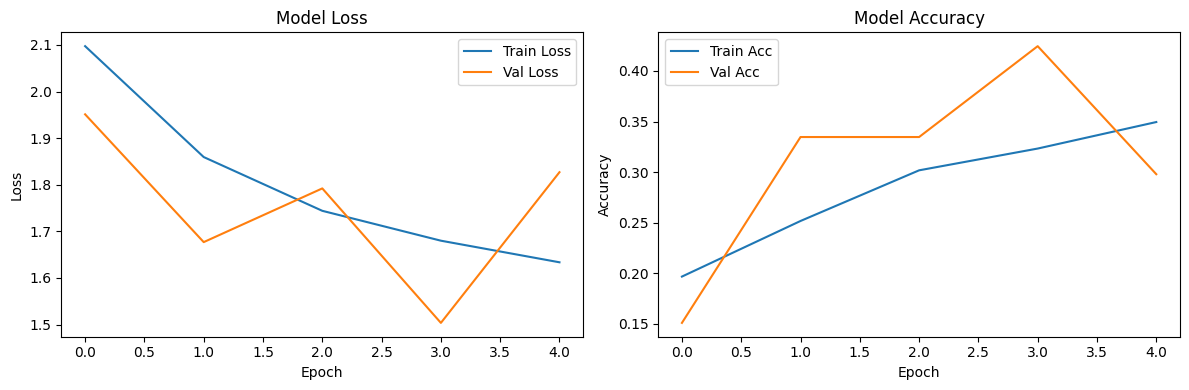

Best model loaded!
Training complete. Ready for evaluation.


In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

best_model = keras.models.load_model('ser_model.keras')
print("Best model loaded!")
print(f"Training complete. Ready for evaluation.")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Test Accuracy: 0.435
Macro F1 Score: 0.445

Classification Report:
              precision    recall  f1-score   support

       angry       0.57      0.63      0.60        41
        calm       0.71      0.43      0.54        35
     disgust       0.58      0.38      0.46        29
     fearful       0.27      0.64      0.38        33
       happy       0.80      0.09      0.16        46
     neutral       0.62      0.56      0.59         9
         sad       0.32      0.31      0.31        36
   surprised       0.39      0.82      0.53        17

    accuracy                           0.43       246
   macro avg       0.53      0.48      0.45       246
weighted avg       0.55      0.43      0.41       246



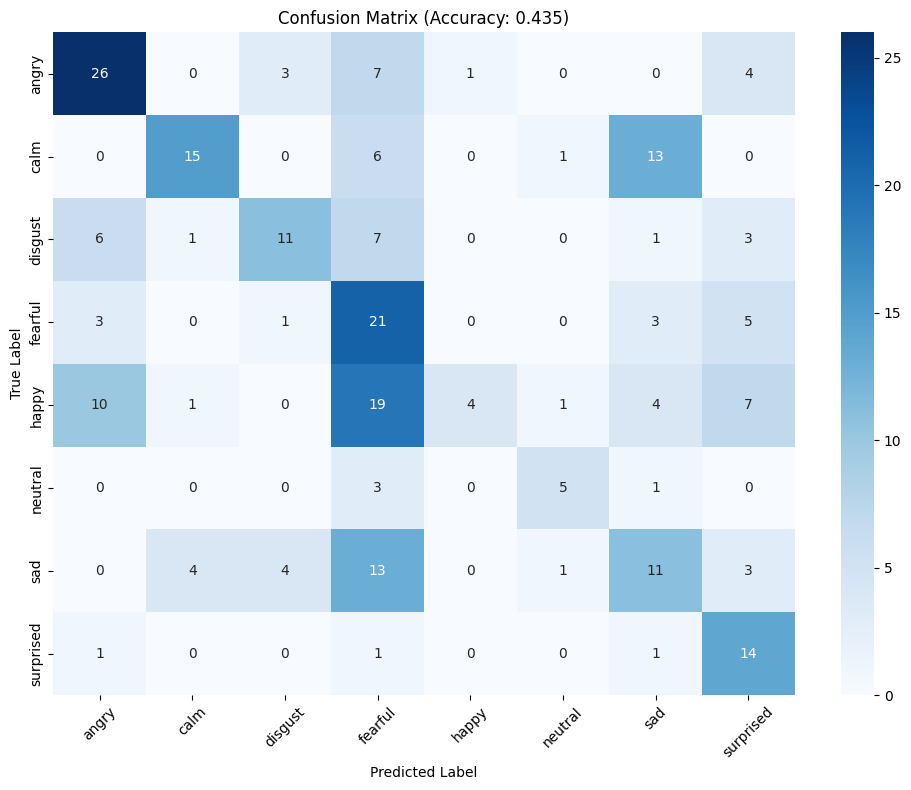

Final metrics - Accuracy: 0.435, Macro F1: 0.445


In [ ]:
# Confusion Matrix
y_pred_proba = best_model.predict(X_test)
y_pred = y_pred_proba.argmax(axis=1)

accuracy = np.mean(y_pred == y_test)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Test Accuracy: {accuracy:.3f}")
print(f"Macro F1 Score: {macro_f1:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_[:len(np.unique(y_test))]))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
class_names = le.classes_[:max(y_pred.max(), y_test.max()) + 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Final metrics - Accuracy: {accuracy:.3f}, Macro F1: {macro_f1:.3f}")


In [40]:
def predict_emotion(file_path, model, le):
    # Load and trim
    y, _ = librosa.load(file_path, sr=16000, mono=True)
    y, _ = librosa.effects.trim(y, top_db=30)
    N_SAMPLES = 48000
    if len(y) < N_SAMPLES:
        y = np.pad(y, (0, N_SAMPLES-len(y)))
    else:
        y = y[:N_SAMPLES]

    # Log-Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=16000, n_fft=1024, hop_length=256, n_mels=64)
    S_db = librosa.power_to_db(S, ref=np.max)
    S_norm = (S_db - S_db.mean()) / (S_db.std() + 1e-6)
    x = S_norm[..., np.newaxis][None, ...]  # Add batch + channel dims

    # Predict
    probs = model.predict(x, verbose=0)[0]
    pred_idx = np.argmax(probs)
    return le.classes_[pred_idx], probs[pred_idx]

# Test prediction
test_idx = np.random.randint(0, len(df))
test_file = df.iloc[test_idx]['path']
true_label = df.iloc[test_idx]['emotion']

pred_label, confidence = predict_emotion(test_file, best_model, le)

print("LIVE DEMO:")
print(f"File: {os.path.basename(test_file)}")
print(f"True: {true_label}")
print(f"Pred: {pred_label} ({confidence:.1%})")
if (pred_label == true_label):
    print("Prediction worked")
print(f"Actor: {df.iloc[test_idx]['gender']}")


LIVE DEMO:
File: 03-01-06-01-01-01-07.wav
True: fearful
Pred: fearful (30.8%)
Prediction worked
Actor: male


In [51]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="ser_best.keras",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

history = model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   epochs=50,
                   callbacks=callbacks)

Epoch 1/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3105 - loss: 1.7694
Epoch 1: val_accuracy improved from None to 0.22449, saving model to ser_best.keras

Epoch 1: finished saving model to ser_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.3106 - loss: 1.7855 - val_accuracy: 0.2245 - val_loss: 1.8762
Epoch 2/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3327 - loss: 1.6846
Epoch 2: val_accuracy did not improve from 0.22449
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.3437 - loss: 1.6653 - val_accuracy: 0.1959 - val_loss: 2.5069
Epoch 3/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3435 - loss: 1.6960
Epoch 3: val_accuracy improved from 0.22449 to 0.41224, saving model to ser_best.keras

Epoch 3: finished saving model to ser_best.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.3580 - loss: 1.6448 - val_accuracy: 0.4122 - val_loss: 1.5831
Epoch 4/50
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.397

In [52]:
model = tf.keras.models.load_model("ser_best.keras")